In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import skew

pd.set_option('max_columns', 500)

In [2]:
df_ng_ypg =  pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Atp6_NG_haploid/YPG/Positions/AllPos_acdc_output/AllPos_acdc_output__156.csv')
df_mk_ypg = pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Atp6_mKate_haploid/YPG/Positions/AllPos_acdc_output/AllPos_acdc_output__235.csv')

In [3]:
dabf2_df_ng = pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Delta_abf2_Atp6_NG/positions/AllPos_acdc_output/AllPos_acdc_output__246.csv')
dabf2_df_mk = pd.read_csv('/volumes/roussou/Microscopy/CellAsic/Delta_abf2_Atp6_mKate/positions/AllPos_acdc_output/AllPos_acdc_output__157.csv')

In [4]:
def normalise_to_median_per_frame(df, intensity_column, max_frame):
    # Check if 'experiment_foldername' column exists in the DataFrame
    if 'experiment_foldername' in df.columns:
        # If it exists, include it in the columns to keep
        columns_to_keep = [
            "experiment_foldername",
            "Position_n",
            "frame_i",
            "Cell_ID",
            "cell_vol_fl",
            intensity_column,
        ]

        # Create 'exp_pos' using both 'experiment_foldername' and 'Position_n'
        df["exp_pos"] = (
            df["experiment_foldername"].astype(str)
            + "_"
            + df["Position_n"].astype(str)
        )
    else:
        # If it doesn't exist, exclude it from the columns to keep
        columns_to_keep = [
            "Position_n",
            "frame_i",
            "Cell_ID",
            "cell_vol_fl",
            intensity_column,
        ]

        # Create 'exp_pos' using only 'Position_n'
        df["exp_pos"] = df["Position_n"].astype(str)

    # Include 'exp_pos' in the columns to keep
    columns_to_keep.append("exp_pos")

    df_processed = df[columns_to_keep]

    df_processed["exp_pos_cell"] = (
        df_processed["exp_pos"].astype(str) + "_"
        + df_processed["Cell_ID"].astype(str)
    )

    df_processed["time"] = (15 * df_processed["frame_i"]).div(60)

    # Filter DataFrame based on the specified maximum frame
    df_processed = df_processed[df_processed.frame_i <= max_frame]

    # Calculate normalization factors using the median per frame
    
    normalization_factors = (
        df_processed.groupby(["exp_pos", "frame_i"])
        [intensity_column]
        .median()
        .reset_index()
        .rename(columns={intensity_column: "norm_factor"})
    )

    df_norm = df_processed.merge(
        normalization_factors, on=["exp_pos", 'frame_i'], how="left"
    )

    normalized_column_name = f"{intensity_column}_norm"
    df_norm[normalized_column_name] = (
        df_norm[intensity_column] / df_norm.norm_factor
    )

    return df_norm

In [5]:
df_ng_ypg_norm = normalise_to_median_per_frame(df=df_ng_ypg, intensity_column="_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=39)
df_mk_ypg_norm = normalise_to_median_per_frame(df=df_mk_ypg, intensity_column="_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=39)

<ipython-input-4-b83f2208d8c2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["exp_pos_cell"] = (
<ipython-input-4-b83f2208d8c2>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["time"] = (15 * df_processed["frame_i"]).div(60)


In [6]:
dabf2_df_ng_norm = normalise_to_median_per_frame(df=dabf2_df_ng, intensity_column="_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=39)
dabf2_df_mk_norm = normalise_to_median_per_frame(df=dabf2_df_mk, intensity_column="_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj", max_frame=39)

<ipython-input-4-b83f2208d8c2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["exp_pos_cell"] = (
<ipython-input-4-b83f2208d8c2>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["time"] = (15 * df_processed["frame_i"]).div(60)


In [22]:
df_ng_ypg_norm.to_csv('df_ng_ypg_norm.csv', index=False)
df_mk_ypg_norm.to_csv('df_mk_ypg_norm.csv', index=False)
dabf2_df_ng_norm.to_csv('dabf2_df_ng_norm.csv', index=False)
dabf2_df_mk_norm.to_csv('dabf2_df_mk_norm.csv', index=False)

In [7]:
def calculate_coefficient_of_variation_last_timepoint(df, column_name):
    unique_exp_pos = set(df['exp_pos'].unique())

    cv_dict = {}

    for exp_pos in unique_exp_pos:
        # Find the last timepoint for the current exp_pos
        last_timepoint = df[df['exp_pos'] == exp_pos]['time'].max()

        # Filter the DataFrame for the last timepoint for the current exp_pos
        df_exp_pos_last_timepoint = df[(df['exp_pos'] == exp_pos) & (df['time'] == last_timepoint)]

        if not df_exp_pos_last_timepoint.empty:
            mean_last_timepoint = df_exp_pos_last_timepoint[column_name].mean()
            std_last_timepoint = df_exp_pos_last_timepoint[column_name].std()
            cv_last_timepoint = std_last_timepoint / mean_last_timepoint
            cv_dict[exp_pos] = cv_last_timepoint

    return cv_dict

In [8]:
### CV based on Norm intensity values

cv_values_mk_ypg = calculate_coefficient_of_variation_last_timepoint(df_mk_ypg_norm, '_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm')
cv_values_mk_abf2 = calculate_coefficient_of_variation_last_timepoint(dabf2_df_mk_norm, '_mKate_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm')

cv_values_ng_ypg = calculate_coefficient_of_variation_last_timepoint(df_ng_ypg_norm, '_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm')
cv_values_ng_abf2 = calculate_coefficient_of_variation_last_timepoint(dabf2_df_ng_norm, '_NG_3D_concentration_autoBkgr_from_vol_fl_meanProj_norm')

In [10]:
cv_mk_ypg = pd.DataFrame(list(cv_values_mk_ypg.items()), columns=['exp_pos', 'cv_mk_ypg'])
cv_mk_abf2 = pd.DataFrame(list(cv_values_mk_abf2.items()), columns=['exp_pos', 'cv_mk_abf2'])

# Merge cv_dfs on 'exp_pos'
cv_mk_df = pd.merge(cv_mk_ypg, cv_mk_abf2, on='exp_pos', how='outer')
cv_mk_df = cv_mk_df.drop(columns=['exp_pos'])

In [11]:
cv_ng_ypg = pd.DataFrame(list(cv_values_ng_ypg.items()), columns=['exp_pos', 'cv_ng_ypg'])
cv_ng_abf2 = pd.DataFrame(list(cv_values_ng_abf2.items()), columns=['exp_pos', 'cv_ng_abf2'])

cv_ng_df = pd.merge(cv_ng_ypg, cv_ng_abf2, on='exp_pos', how='outer')
cv_ng_df = cv_ng_df.drop(columns=['exp_pos'])

In [12]:
# Calculate the mean for each DataFrame
mean_ng = cv_ng_df.mean()

# Calculate the standard deviation for each DataFrame
std_ng = cv_ng_df.std()

# Melt the DataFrame for the swarm plot
cv_ng_melted = cv_ng_df.melt(var_name='DataFrame', value_name='CoV')

cv_ng_melted = cv_ng_melted.dropna()

In [13]:
# Calculate the mean for each DataFrame
mean_mk = cv_mk_df.mean()

# Calculate the standard deviation for each DataFrame
std_mk = cv_mk_df.std()

# Melt the DataFrame for the swarm plot
cv_mk_melted = cv_mk_df.melt(var_name='DataFrame', value_name='CoV')

cv_mk_melted = cv_mk_melted.dropna()

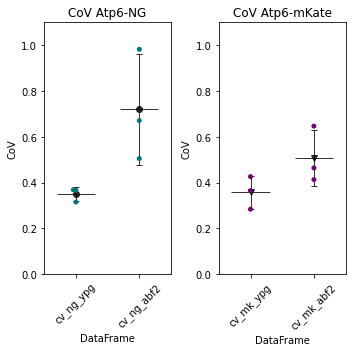

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figsize as needed

# Plot the first swarm plot on ax1
swarm1 = sns.swarmplot(data=cv_ng_melted, x='DataFrame', y='CoV', ax=ax1, color='#007676')
ax1.set_title('CoV Atp6-NG') 
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45) 

# Calculate the mean and standard deviation for the first swarm plot
mean_ng_std = cv_ng_melted.groupby('DataFrame', sort=False)['CoV'].agg(['mean', 'std'])
x_values_ng = np.arange(len(mean_ng_std))

# Plot mean with error bars on ax1
ax1.errorbar(x=x_values_ng, y=mean_ng_std['mean'], yerr=mean_ng_std['std'], fmt='o', color='black', linewidth=1, capsize=3, alpha=0.8, label='Mean ± Std Dev NG')

# Add lines to represent the mean on ax1
for i, mean in enumerate(mean_ng_std['mean']):
    ax1.hlines(mean, i - 0.3, i + 0.3, colors='k', alpha=0.8, linewidth=1, label='Mean')

ax1.set_ylim(0, 1.1)

# Plot the second swarm plot on ax2
swarm2 = sns.swarmplot(data=cv_mk_melted, x='DataFrame', y='CoV', ax=ax2, color='#760076')
ax2.set_title('CoV Atp6-mKate')  
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45) 

# Calculate the mean and standard deviation for the second swarm plot
mean_mk_std = cv_mk_melted.groupby('DataFrame', sort=False)['CoV'].agg(['mean', 'std'])
x_values_mk = np.arange(len(mean_mk_std))

# Plot mean with error bars on ax2
ax2.errorbar(x=x_values_mk, y=mean_mk_std['mean'], yerr=mean_mk_std['std'], fmt='v', color='black', linewidth=1, capsize=3, alpha=0.8, label='Mean ± Std Dev MK')

# Add lines to represent the mean on ax2
for i, mean in enumerate(mean_mk_std['mean']):
    ax2.hlines(mean, i - 0.3, i + 0.3, colors='k', alpha=0.8, linewidth=1, label='Mean')

ax2.set_ylim(0, 1.1)

plt.tight_layout(rect=[0, 0, 0.5, 1])  # Rect parameter adjusts the space for the suptitle
#plt.savefig('CoV_ypg_abf2_haploids_10hrs_norm.svg', transparent = True)